In [1]:
import os
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter

from PIL import Image,ImageFile
import albumentations as A
import matplotlib.pyplot as plt

from sklearn import model_selection
# import segmentation_models_pytorch as smp

import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

ImageFile.LOAD_TRUNCATED_IMAGES = True
# device="cpu"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Utility Functions Provided by Kaggle**

* Here is the utility function which is used to create mask from this **Run Length Encoding**(RLE) data.

In [2]:
def run_length_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

In [3]:
def preprocess_input(x, mean=None, std=None, input_space="RGB", input_range=None):

    if input_space == "BGR":
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.0

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x


In [4]:
class SIIMDataset(Dataset):
    
    def __init__(self, df, data_dir, transform=None, preprocessing_fun=None, channel_first=True):
        self.data_dir = data_dir
        self.transform = transform                       # for augmentations
        self.preprocessing_fun = preprocessing_fun       # preprocessing_fun to normalize images
        self.channel_first = channel_first               # set channels as first dimension
        self.image_ids = df.ImageId.values
        self.group_by = df.groupby('ImageId')

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        df = self.group_by.get_group(img_id)
        annotations = df[' EncodedPixels'].tolist()
        
        img_path = os.path.join(self.data_dir, img_id + ".png")
        img = Image.open(img_path).convert('RGB')
        img = np.array(img)

        mask = np.zeros(shape=(1024,1024))
        if annotations[0] != ' -1':
            for rle in annotations:
                mask += run_length_decode(rle)
        mask = (mask >= 1).astype('float32')
        mask = np.expand_dims(mask, axis=-1)
        
        # apply augmentation
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        if self.preprocessing_fun:
            img = self.preprocessing_fun(img,
                                         input_range=[0, 1],
                                         mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        
        # convert shape from (width, height, channel) ----> (channel, width, height) 
        if self.channel_first:
            img = np.transpose(img, (2, 0, 1)).astype(np.float32)
            mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

        return {
            'image': torch.Tensor(img),
            'mask': torch.Tensor(mask)
        }

In [5]:
def train(data_loader, model, criterion, optimizer):
    model.train()
    train_loss = 0
    for data in tqdm(data_loader):
        inputs = data['image']
        labels = data['mask']

        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    return train_loss/len(data_loader)

In [6]:
def evaluate(data_loader, model, criterion):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for data in tqdm(data_loader):
            inputs = data['image']
            labels = data['mask']

            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()

    return eval_loss/len(data_loader)

# U-Net Implementation

In [23]:
def double_convolution(in_channels,out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.ReLU(inplace=True)
    )
    return conv


def crop_image_tensor(original_tensor,target_tensor):
    """
    format of tensor in pytorch batch_size,channels,Height,Width
    original_tensor:tensor to crop
    target_tensor:target tensor which shoukd be smaller than original tensor
    """
    original_tensor_size = original_tensor.size()[-1]
    target_tensor_size = target_tensor.size()[-1]
    #change = math.ceil((original_tensor_size - target_tensor_size)/2)
    change = original_tensor_size - target_tensor_size
    left=change//2
    right=change-left
    #print("x {} y {} change {}".format(original_tensor_size, target_tensor_size, change))
    # change =change//2
    # x = original_tensor.size()[-1]
    # y = target_tensor.size()[-1]
    # change = max(math.floor((x-y)/2), ((x-y)//2))
    
    new = original_tensor[:,:,left:original_tensor_size - right ,left:original_tensor_size - right]
    
    return new
    



class UNet(nn.Module):

    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2_x_2 = nn.MaxPool2d(stride=2,kernel_size=2)

        self.down_conv_block_1 = double_convolution(3,64)
        self.down_conv_block_2 = double_convolution(64,128)
        self.down_conv_block_3 = double_convolution(128,256)
        self.down_conv_block_4 = double_convolution(256,512)
        self.down_conv_block_5 = double_convolution(512,1024)

        self.up_transpose_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2,stride=2)
        self.up_conv_block_1 = double_convolution (1024,512)

        self.up_transpose_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2,stride=2)
        self.up_conv_block_2 = double_convolution (512,256)

        self.up_transpose_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2,stride=2)
        self.up_conv_block_3 = double_convolution (256,128)

        self.up_transpose_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2,stride=2)
        self.up_conv_block_4 = double_convolution (128,64)

        self.output =nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1)

    def forward(self,image):
        """
        bs,C,H,W
        Contacting Path

        """

        x1 =self. down_conv_block_1(image) ##concat1
        # print(x1.size())
        x2 = self.max_pool_2_x_2(x1)
        x3 = self. down_conv_block_2(x2)##concat2
        x4 = self.max_pool_2_x_2(x3)
        x5 = self. down_conv_block_3(x4)##concat3
        x6 = self.max_pool_2_x_2(x5)
        x7 = self. down_conv_block_4(x6)##concat4
        x8 = self.max_pool_2_x_2(x7)
        x9 = self. down_conv_block_5(x8)
        # print(x9.size())

        x = self.up_transpose_1(x9)
        y = crop_image_tensor(x7,x)
        print(x.size())
        print(y.size())
        x = self.up_conv_block_1(torch.cat([x,y],axis=1))

        x = self.up_transpose_2(x)
        y = crop_image_tensor(x5,x)
        print(x.size())
        print(y.size())
        x = self.up_conv_block_2(torch.cat([x,y],axis=1))

        x = self.up_transpose_3(x)
        y = crop_image_tensor(x3,x)
        x = self.up_conv_block_3(torch.cat([x,y],axis=1))

        x = self.up_transpose_4(x)
        y = crop_image_tensor(x1,x)
        x = self.up_conv_block_4(torch.cat([x,y],axis=1))

        #print("size of cropped x7",x.size())

        output =self.output(x)
        # print(output)
        # print(output.size())
        return output

# if __name__== "__main__":
#     image =torch.rand((1,3,572,572))
#     model = UNet()
#     print(model(image).size())



In [9]:

DATA_DIR = '../input/siim-png-images/train_png'
data_csv = '../input/siim-acr-pneumothorax-segmentation-data/train-rle.csv'
batch_size = 16


In [10]:

transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.OneOf([A.RandomGamma(gamma_limit=(90,110)),
             A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)], p=0.5),
    A.Resize(width=224, height=224)
])

In [11]:
df = pd.read_csv(data_csv)
df_train, df_val = model_selection.train_test_split(df, test_size=0.15)

In [12]:
train_dataset = SIIMDataset(df_train,
                            DATA_DIR,
                            transform = transform,
                            preprocessing_fun = preprocess_input)

val_dataset = SIIMDataset(df_val,
                          DATA_DIR,
                          transform = transform,
                          preprocessing_fun = preprocess_input)

train_loader = DataLoader(train_dataset,
                          batch_size = batch_size,
                          shuffle = True,
                          num_workers = 8)

val_loader = DataLoader(val_dataset,
                        batch_size = batch_size,
                        num_workers = 4)

In [13]:
print('Training data Info:')
dataiter = iter(train_loader)
data = dataiter.next()
images,labels = data['image'],data['mask']
print("shape of images : {}".format(images.shape))
print("shape of labels : {}".format(labels.shape))

print('\nValidation data Info:')
dataiter = iter(val_loader)
data = dataiter.next()
images,labels = data['image'],data['mask']
print("shape of images : {}".format(images.shape))
print("shape of labels : {}".format(labels.shape))

Training data Info:
shape of images : torch.Size([16, 3, 224, 224])
shape of labels : torch.Size([16, 1, 224, 224])

Validation data Info:
shape of images : torch.Size([16, 3, 224, 224])
shape of labels : torch.Size([16, 1, 224, 224])


# **Create Loss Class Defined By Kaggle**

* Here, Dice Loss is define as well as Focal Loss is also created to get better results.
* For this notebook, I have used the combination of two loss: diceloss and focalloss

In [15]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha=None, gamma=None):
        super().__init__()

    def forward(self, input, target):
        loss = -torch.log(dice_loss(input, target))

        return loss.mean()

# **Train The Model**

In [24]:
# Create Model
model = UNet()
model.to(device)


UNet(
  (max_pool_2_x_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_block_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_block_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_block_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_block_5): Sequential(
  

In [20]:
epochs = 3
train_loss_ = []
val_loss_ = []

for epoch in range(epochs):

    train_loss = train(train_loader,
                       model,
                       criterion,
                       optimizer)
    train_loss_.append(train_loss)

    val_loss = evaluate(val_loader,
                        model,
                        criterion)
    val_loss_.append(val_loss)


    print(f'Epoch: {epoch+1}')
    print(f'Train Loss: {train_loss}, \t Valid Loss: {val_loss}\n')
    

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 4.981844440683142, 	 Valid Loss: 5.297985829344583



  0%|          | 0/616 [00:00<?, ?it/s]

Epoch: 2
Train Loss: 5.023431844525523, 	 Valid Loss: 5.303195629644831



100%|██████████| 109/109 [00:51<00:00,  2.12it/s]

Epoch: 3
Train Loss: 4.981472322693119, 	 Valid Loss: 5.305510717794435



# Train and Val Loss Curves

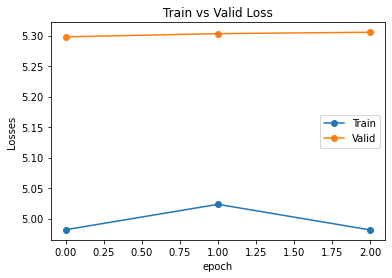

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_loss_,'-o')
plt.plot(val_loss_,'-o')
plt.xlabel('epoch')
plt.ylabel('Losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')

plt.show()